In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#only need to change the paths here 
test_folder="/content/gdrive/My Drive/solar_energie_project/test/"
test_folder_Yolo="/content/gdrive/My Drive/solar_energie_project/darknet/data/test/"
output_folder="/content/gdrive/My Drive/solar_energie_project/darknet/result_img/"
project="/content/gdrive/MyDrive/solar_energie_project/"

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from PIL import Image
import shutil
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array, array_to_img

# all functions will be used 
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
def change_file_name_in_folder(folder):
    for count, filename in enumerate(os.listdir(folder)):
        dst = str(count+1000) + ".jpg"
        src = folder+ "/"+ filename
        dst = folder+ "/"+ dst
        # rename all the files
        os.rename(src, dst)
    for count, filename in enumerate(os.listdir(folder)):
        dst = str(count+1) + ".jpg"
        src = folder+ "/"+ filename
        dst = folder+ "/"+ dst
        # rename all the files
        os.rename(src, dst)
def remove_img(path, img_name):
    os.remove(path + '/' + img_name)

# Rooftop detection with YOLOv4

In [ ]:
os. chdir(project)

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/gdrive/MyDrive/solar_energie_project/darknet


In [ ]:
# it takes about 2 minutes
!make

In [ ]:
!chmod +x ./darknet # change permission for darknet folder- to be excutable

In [ ]:
#change the content of configuration file
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/gdrive/MyDrive/solar_energie_project/darknet/cfg
/content/gdrive/MyDrive/solar_energie_project/darknet


In [ ]:
change_file_name_in_folder(test_folder)

### start from here after the first test to spare time

In [ ]:
#for new image it needs only be changed here
image_input=test_folder+"3.jpg"

In [ ]:
cd darknet

/content/gdrive/MyDrive/solar_energie_project/darknet


In [ ]:
#empty the output folder

change_file_name_in_folder(output_folder)
while True:
  images = []
  images = load_images_from_folder(output_folder)
  print(len(images))
  #remove all files
  for i in range(len(images)):
      if os.path.exists(output_folder+str(i+1)+".jpg"):
        remove_img(output_folder,str(i+1)+".jpg")
      else:
          continue
  if(len(images)==0):
    break
#check again 
len(images)

2
0


0

In [ ]:
#empty the test folder of YOLO

change_file_name_in_folder(test_folder_Yolo)
while True:
  images = []
  images = load_images_from_folder(test_folder_Yolo)
  print(len(images))
  #remove all files
  for i in range(len(images)):
      if os.path.exists(test_folder_Yolo+str(i+1)+".jpg"):
        remove_img(test_folder_Yolo,str(i+1)+".jpg")
      else:
          continue
  if(len(images)==0):
    break
#check again 
len(images)

1
0


0

In [ ]:
#copy all test images to test folder of Yolo
newPath = shutil.copy(image_input, test_folder_Yolo+"1.jpg")

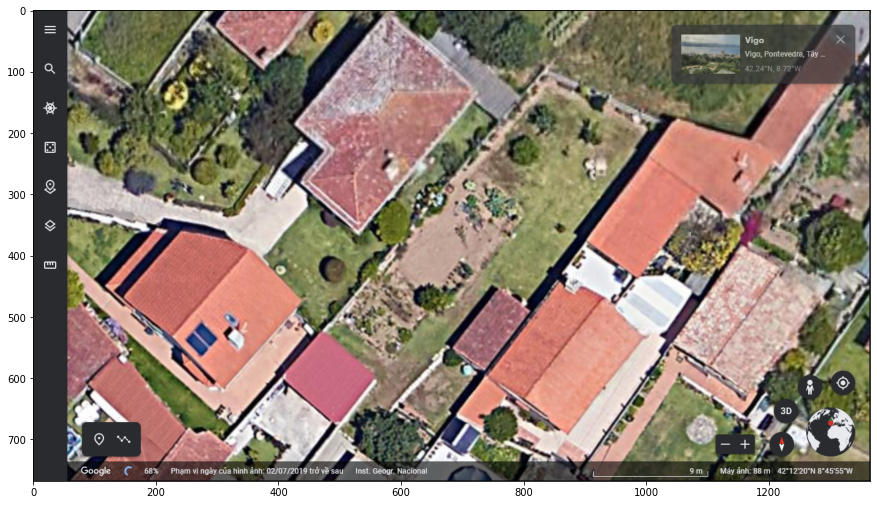

In [ ]:
#showing image input
plt.figure(figsize=(15, 15))
im = Image.open(image_input) 
im = np.array(im) 
plt.imshow(im)

In [ ]:
# roof in image input detection 
!./darknet detector test data/roof.data cfg/yolov4-custom.cfg backup/yolov4-custom_best.weights -ext_output data/test/1.jpg -thresh 0.5

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

# Rooftop equipped with solar panels classification

In [ ]:
#changing name of image files in folder result_img
change_file_name_in_folder("result_img")
# checking amount of detected rooves from the input image 
images = []
images = load_images_from_folder("result_img")
len(images)

4

In [ ]:
class_names = ['roof with solar', 'roof without solar']

In [ ]:
os. chdir(project)

In [ ]:
# roof with or without solar classification
labels=[]
for i in range(len(images)):
  img = Image.open("darknet/result_img/"+str(i+1)+".jpg").resize((224, 224), Image.ANTIALIAS) #loading all roof images detected by YOLOv4
  img = np.array(img)
  new_model = tf.keras.models.load_model('solar_classification_optimized.h5') # using trained model
  y_pred = new_model.predict(img[None,:,:])
  y_classes = [np.argmax(element) for element in y_pred]
  labels.append(y_classes[0])  
  #print(labels)


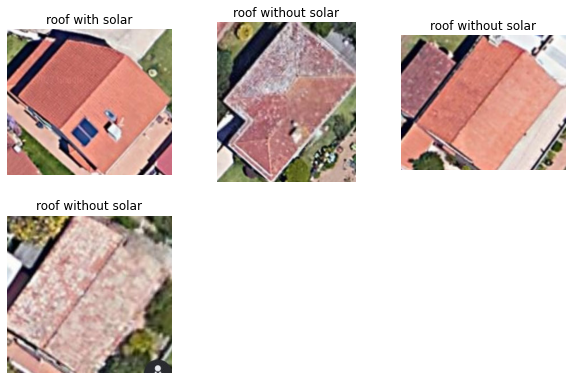

In [ ]:
#showing results
plt.figure(figsize=(10, 10))
if (len(images)<=9): #only plot maximum 9 images
  for i in range((len(images))):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [ ]:
#delete images without solar pannels in folder- only keep the ones with solar
for i in range(len(images)):
  if (class_names[labels[i]]!= "roof with solar"):
    if os.path.exists("darknet/result_img/"+str(i+1)+".jpg"):
      remove_img("darknet/result_img",str(i+1)+".jpg")
    else:
        continue

# Rooftop shape classification

In [ ]:
#changing name of image files in folder result_img
change_file_name_in_folder("darknet/result_img")
# checking amount of roof with solar pannel from the input image 
images = []
images = load_images_from_folder("darknet/result_img")
len(images)

1

In [ ]:
#['flat', 'gable', 'hip']
class_names_1 = ['flat', 'gable', 'hip']

In [ ]:
# roof shape classification
labels1=[]
for i in range(len(images)):
  img = Image.open("darknet/result_img/"+str(i+1)+".jpg").resize((224, 224), Image.ANTIALIAS) # load images
  img = np.array(img)
  new_model = tf.keras.models.load_model('roof shape_classification_optimized.h5')  #using trained model
  y_pred = new_model.predict(img[None,:,:])
  y_classes = [np.argmax(element) for element in y_pred]
  labels1.append(y_classes[0])  


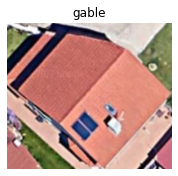

In [ ]:
# showing results
plt.figure(figsize=(10, 10))
for i in range((len(images))):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
  plt.title(class_names_1[labels1[i]])
  plt.axis("off")

# Rooftop direction detection

In [ ]:
class_names_2 = ['east', 'south', 'southeast', 'southwest',"south", "southwest+southeast","straight toward the sun"]

In [ ]:
labels2=[]
for i in range(len(images)):
  img = Image.open("darknet/result_img/"+str(i+1)+".jpg").resize((224, 224), Image.ANTIALIAS) #load images
  img = np.array(img)
  # for gable rooves
  if (labels1[i]==1):
    new_model = tf.keras.models.load_model('gable roof direction_classification_optimized.h5')
    y_pred = new_model.predict(img[None,:,:])
    y_classes = [np.argmax(element) for element in y_pred]
  #for hip rooves
  if (labels1[i]==2):
    new_model = tf.keras.models.load_model('hip roof direction_classification_optimized.h5')
    y_pred = new_model.predict(img[None,:,:])
    y_classes = [np.argmax(element) for element in y_pred]
  labels2.append(y_classes[0])  
  

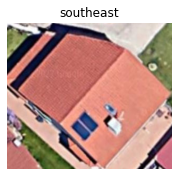

In [ ]:
#showing results
plt.figure(figsize=(10, 10))
for i in range((len(images))):
  if (labels1[i]==0):
    labels2[i]=6
  if (labels1[i]==2):
    labels2[i]= labels2[i]+4
  ax = plt.subplot(3,3, i+1)
  plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
  plt.title(class_names_2[labels2[i]])
  plt.axis("off")

# Calculation area of solar panels on detected roofs

In [ ]:
os.chdir(project)

In [ ]:

def dice_coef(y_true, y_pred): #dice_coef is the F1 score
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
# Unet model
def get_unet_128(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coef])

    return model


In [ ]:
#converting imaga size to the same input size
def data_generator(images_path):
    while True:
        img_size=[128, 128, 3]
        imgs = []
        img = load_img(images_path, target_size=img_size) 
        imgs.append(img_to_array(img))
        yield np.array(imgs, dtype=np.float16) / 255.
#calculating the area of white pixels (the solar panels on roofs)
def white_area_calculation(mask):
  pixel_in_m = 0.0002645833333 #1 pixel=0.000264583333 m
  height = mask.shape[0]*pixel_in_m
  width = mask.shape[1]*pixel_in_m
  area_of_mask= height*width
  number_of_white_pix = np.sum(mask == 1)
  number_of_black_pix = np.sum(mask == 0)
  area_of_white_pixel=area_of_mask*number_of_white_pix/(number_of_white_pix+number_of_black_pix)
  return area_of_white_pixel #in m^2

In [ ]:
#all need to load model is add all functions
trained_model = keras.models.load_model(
    "segmentation_model", custom_objects={"CustomModel": get_unet_128,"dice_loss":dice_loss, "dice_coef": dice_coef,"bce_dice_loss":bce_dice_loss })

In [ ]:
#converting the test image into the same size of the model input to be able to use the model
path = "/content/gdrive/MyDrive/solar_energie_project/darknet/result_img/" # path of test image
convert_img=[]
for i in range((len(images))):
  gen = data_generator(path+str(i+1)+".jpg")
  img = next(gen)
  convert_img.append(img)
len(convert_img)

1

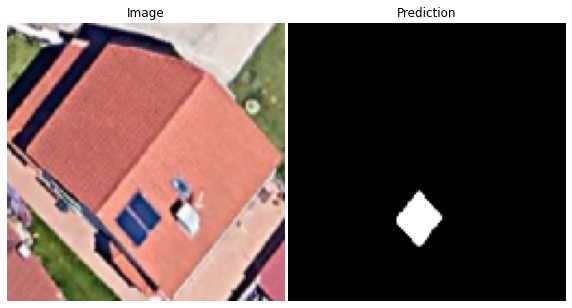

In [ ]:
mask=[]
for i in range((len(convert_img))):
  pred_mask = trained_model.predict(convert_img[i])
  mask.append(pred_mask)
  fig, ax = plt.subplots(1, 2, figsize=(10,10))
  fig.subplots_adjust(hspace=.1, wspace=.01)
  ax[0].imshow(convert_img[i][0].astype(np.float32))
  ax[0].axis('off')
  ax[0].title.set_text('Image')
  ax[1].imshow(pred_mask[0,:,:,0], cmap='gray')
  ax[1].axis('off')
  ax[1].title.set_text('Prediction')


In [ ]:
#resizing the mask to its original one to calculate the area afterwards
original_mask=[]
for i in range ((len(mask))):
  mask[i] =mask[i][0,:,:,:]# only take the last 3 demension
  orginal_img = cv2.imread(path+str(i+1)+".jpg")
  mask[i] = cv2.resize(mask[i], (orginal_img.shape[1], orginal_img.shape[0])) 
  original_mask.append(mask[i])

In [ ]:
#the pixels of images are float, so it needs to be rounded to int pixel 
for x in range ((len(original_mask))):
  for i in range(original_mask[x].shape[0]):
    for j in  range(original_mask[x].shape[1]):
      original_mask[x][i][j]=round(original_mask[x][i][j])
  print(original_mask[x].shape)

(279, 314)


In [ ]:
for i in range ((len(original_mask))):
  print("Area of solar pannels in image "+str(i+1)+" is " + str(white_area_calculation(original_mask[i]))+" m^2")


Area of solar pannels in image 1 is 0.00011137690535388095 m^2
